## Feature Selection Chi^2

## Imports

In [1]:
# System functionality
import sys
sys.path.append('..')

import glob
import os
import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import graphviz
import math as math
import json
import cv2
import scipy.stats as stats
import matplotlib.image as mpimg
import sklearn.feature_selection as feature_selection
from skimage import data, io, filters
from numpy import linspace
from numpy.core.umath import pi
from matplotlib.ticker import FuncFormatter
from matplotlib.font_manager import FontProperties
from emoji_extractor.extract import Extractor
from emojipedia import Emojipedia
from skimage import io
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2_contingency
from scipy.interpolate import spline

## Load

In [2]:
path__tweets_csv = '/home/stelios/Desktop/Honours Project/Samples/tweet_data/tweets_joh_all.csv'
path_users_csv = '/home/stelios/Desktop/Honours Project/Samples/user_data/joh.csv'

joh_tweets_df = pd.read_csv(path__tweets_csv,index_col=None, header=0, low_memory = False).applymap(str)
joh_users_df = pd.read_csv(path_users_csv,index_col=None, header=0, low_memory = False).applymap(str)

joh_join_df = joh_tweets_df.join(joh_users_df.set_index('user_id'), on='user_id')

del joh_tweets_df
del joh_users_df

## Bar Chart Formatters

In [3]:
# Millions Formatter Function
def millions(x,pos):
    return '%1.1fK' % (x*1e-3)

# Power of 10 Formatter Function (y log scale bug, so i have created this formatter)
def pow10(x,pos):
    return "{:.0f}\n10 ".format(x)

# Power of 10 (1 d.p) Formatter Function (y log scale bug, so i have created this formatter)
def pow10_1dp(x,pos):
    return "{:.1f}\n10     ".format(x)

# Percenatge Formatter Function
def percentage(x,pos):
    return "{:.1f}%".format(x*100)

# Create a formatters
formatter_millions = FuncFormatter(millions)
formatter_pow10 = FuncFormatter(pow10)
formatter_pow10_1dp = FuncFormatter(pow10_1dp)
formatter_percentage = FuncFormatter(percentage)

# Use TwitterColorEmoji Font (only one supporting emojis) 
emojis_font = FontProperties(fname='./Fonts/TwitterColorEmoji-SVGinOT.ttf',size=55)

## Colours

In [4]:
colors_seagreen_fade=["#f3f8f3","#e8f1e8","#ddeadd","#d2e4d2","#c7ddc7","#bbd6bb","#b0d0b0","#a5c9a5","#9ac29a","#8fbc8f","#80a980","#729672","#648364","#557055","#475e47","#394b39"]

colors_orange_fade=["#fff6e5","#ffedcc","#ffe4b2","#ffdb99","#ffd27f","#ffc966","#ffc04c","#ffb732","#ffae19","#ffa500","#e59400","#cc8400","#b27300","#996300","#7f5200","#664200"]

colors_dodgeblue_fade=["#e7f1fa","#d0e3f5","#b9d5f0","#a2c7eb","#8bb9e6","#74abe1","#5d9ddc","#468fd7","#2f81d2","#1874cd","#1568b8","#135ca4","#10518f","#0e457b","#0c3a66","#092e52"]

colors_indianred_fade=["#faeeee","#f5dddd","#f0cccc","#ebbbbb","#e6aaaa","#e19999","#dc8888","#d77676","#d26666","#cd5555","#b84c4c","#a44444","#8f3b3b","#7b3333","#662a2a","#522222"]

## Emojis on Bar Chart Function

In [5]:
def bar_chart_plot_emojis(ax,fig,x,y):
    # Set sizes of figure and images
    ax_width = ax.get_window_extent().width
    fig_width = fig.get_window_extent().width
    fig_height = fig.get_window_extent().height
    img_size = ax_width/(fig_width*len(x_linespace))
    img_axs = [None for i in range(len(x_linespace))]
    
    ##delete
    #a = io.imread(Emojipedia.search(x[1]).platforms[5].image_url)

    # Display emojis pngs on x-axis
    for i in range(len(x)):
        loc = ax.transData.transform((x_linespace[i], y[i]))      # Optimize y manually 
        img_axs[i] = fig.add_axes([loc[0]/fig_width-img_size/2, loc[1]/fig_height-img_size/2,
                                   img_size, img_size], anchor='C')

        # Platform 5 = Twitter
        img_axs[i].imshow(io.imread(Emojipedia.search(x[i]).platforms[5].image_url))
        img_axs[i].axis("off")
        
        ##delete
        #img_axs[i].imshow(a)
        #img_axs[i].axis("off")

## Count

In [6]:
extract = Extractor()
count = extract.count_all_emoji(joh_join_df['text'])

## Extract Emojis for All

In [7]:
# Create panda dataframe to store emojis with counts
emojis_count_df = pd.DataFrame(columns = ['Emoji','Count'])
for emoji in count:
    emojis_count_df = emojis_count_df.append({'Emoji' : emoji , 'Count' : count[emoji]} , ignore_index=True)

# Sort dataframe by count
emojis_count_df = emojis_count_df.sort_values(by=['Count'])

# Print size of tweets
print(len(joh_join_df['text']))

# Show last 20 (sorted)
emojis_count_df.tail(20)

2308977


,Emoji,Count
52,💙,5224
33,😅,6049
25,😁,7146
0,😉,7402
34,🎉,7477
217,💕,7961
57,🙄,8248
53,👀,8372
28,🤔,8532
88,👍,9408


## Emoji frequencies per tweet

In [8]:
length_emojis = len(emojis_count_df['Emoji'].values)
print(length_emojis)
length_tweets = len(joh_join_df['text'])

# Avoid Low Memory Error
from scipy.sparse import *
from scipy import *
zeros_matrix = csr_matrix( (length_tweets,length_emojis), dtype=int8 ).todense()

# Fill pandas dataframe with zeros
emojis_count_create_df = pd.DataFrame(zeros_matrix,columns = emojis_count_df['Emoji'].values)
emojis_count_create_df

#countloop =0
extract = Extractor()

# Add the frequencies of each emoji by Tweet
for enum,text in enumerate (joh_join_df['text']):
    #countloop = countloop+1
    #print(countloop)
    text_count_emoji = extract.count_emoji(text, check_first=True)
    if(len(text_count_emoji)==0):
        #print("Non")
        pass
    else:
        for emoji in text_count_emoji:
            #print(emoji)
            emojis_count_create_df.at[enum, emoji] = text_count_emoji[emoji]
# Describe throws memory error
##emojis_count_create_df.describe() 
emojis_count_create_df.info(memory_usage='deep')

2213
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2308977 entries, 0 to 2308976
Columns: 2213 entries, 🧒🏽 to 😂
dtypes: int8(2213)
memory usage: 4.8 GB


## ChiSquare Class

In [9]:
class ChiSquare:
    
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        self.dfObserved = None
        self.dfExpected = None
        
    def _print_chisquare_result(self, colX, alpha,emoji_dictionary):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT".format(colX)
            
        else:
            result="{0} is NOT an important".format(colX)
        #print("{}  {}".format(result,self.p))
        emoji_dictionary[colX]=self.p
    
    def TestIndependence(self,colX,colY,emoji_dictionary, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        #print("{} ".format(chi2))
        self._print_chisquare_result(colX,alpha,emoji_dictionary)

## Add (Black vs Not Black) on Table

In [10]:
## Avoid an error with assignment
#pd.options.mode.chained_assignment = None

## Drop Ethnicity and add (black, not black)
emojis_count_create_df['ethnicity']= joh_join_df['ethnicity']
emojis_count_create_df.ethnicity[emojis_count_create_df.ethnicity!="black"] = "not black"

/home/stelios/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
emojis_count_create_df

,🧒🏽,👱🏾,👩🏽‍💼,👨🏼‍🔬,🍘,🏄🏿‍♂️,🧪,🇧🇼,👨🏻‍🚒,🤜🏿,...,😘,👏,😊,🔥,😍,🤣,😭,❤,😂,ethnicity
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,not black
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,not black
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,not black
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,not black
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,not black
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,not black
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,not black
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,not black
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,not black
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,not black


## Chi Sqaure Black vs Not Black

In [12]:
#Initialize ChiSquare Class
cTblack = ChiSquare(emojis_count_create_df)

#Feature Selection
emoji_dict={}
for emoji in emojis_count_df['Emoji'].values:
    cTblack.TestIndependence(colX=emoji,colY="ethnicity",emoji_dictionary=emoji_dict)
print("Done 1")
# Mean for black(+) - Mean for non black(-)
mean_black = emojis_count_create_df.loc[emojis_count_create_df['ethnicity'] == 'black'].mean() - emojis_count_create_df.loc[emojis_count_create_df['ethnicity'] == 'not black'].mean()
mean_black_dict = mean_black.to_dict()
print("Done 2")
# Sorted by uncorrelated
sorted_by_value_black = sorted(emoji_dict.items(), key=lambda kv: kv[1])
print("Done 3")
# Dictionary sorted by uncorrelated emojis with gender
sorted_black = {}
for key,value in sorted_by_value_black:
    for key2 in mean_black_dict:
        if(key==key2):
            if(mean_black_dict[key2]>0):
                sorted_black[key]='black'
            elif(mean_black_dict[key2]<0):
                sorted_black[key]='not black'
            else:
                sorted_black[key]='Same'
print("Done 4")                
# Dataframe to plot
df_to_plot_black = pd.DataFrame(data=sorted_by_value_black,columns=['Emoji','P-value'])
df_to_plot_black['ethnicity'] = sorted_black.values()
df_to_plot_black

Done 1
Done 2
Done 3
Done 4


,Emoji,P-value,ethnicity
0,🤦🏾‍♀️,0.000000e+00,black
1,🤷🏾‍♀️,0.000000e+00,black
2,🔉,0.000000e+00,black
3,💪🏾,0.000000e+00,black
4,👊🏾,0.000000e+00,black
5,🤦🏾‍♂️,0.000000e+00,black
6,🔊,0.000000e+00,black
7,🤷🏽‍♀️,0.000000e+00,black
8,👌🏾,0.000000e+00,black
9,🤷🏾‍♂️,0.000000e+00,black


In [13]:
df_to_plot_black.to_csv("/home/stelios/Desktop/Honours Project/Emojis-usage-in-social-media-by-demographics/Jupyter/P-values/chi2_joh_black_pvalues.csv",encoding='utf-8', index=False)
del df_to_plot_black

## Top 20 Distinct Emojis by Blacks

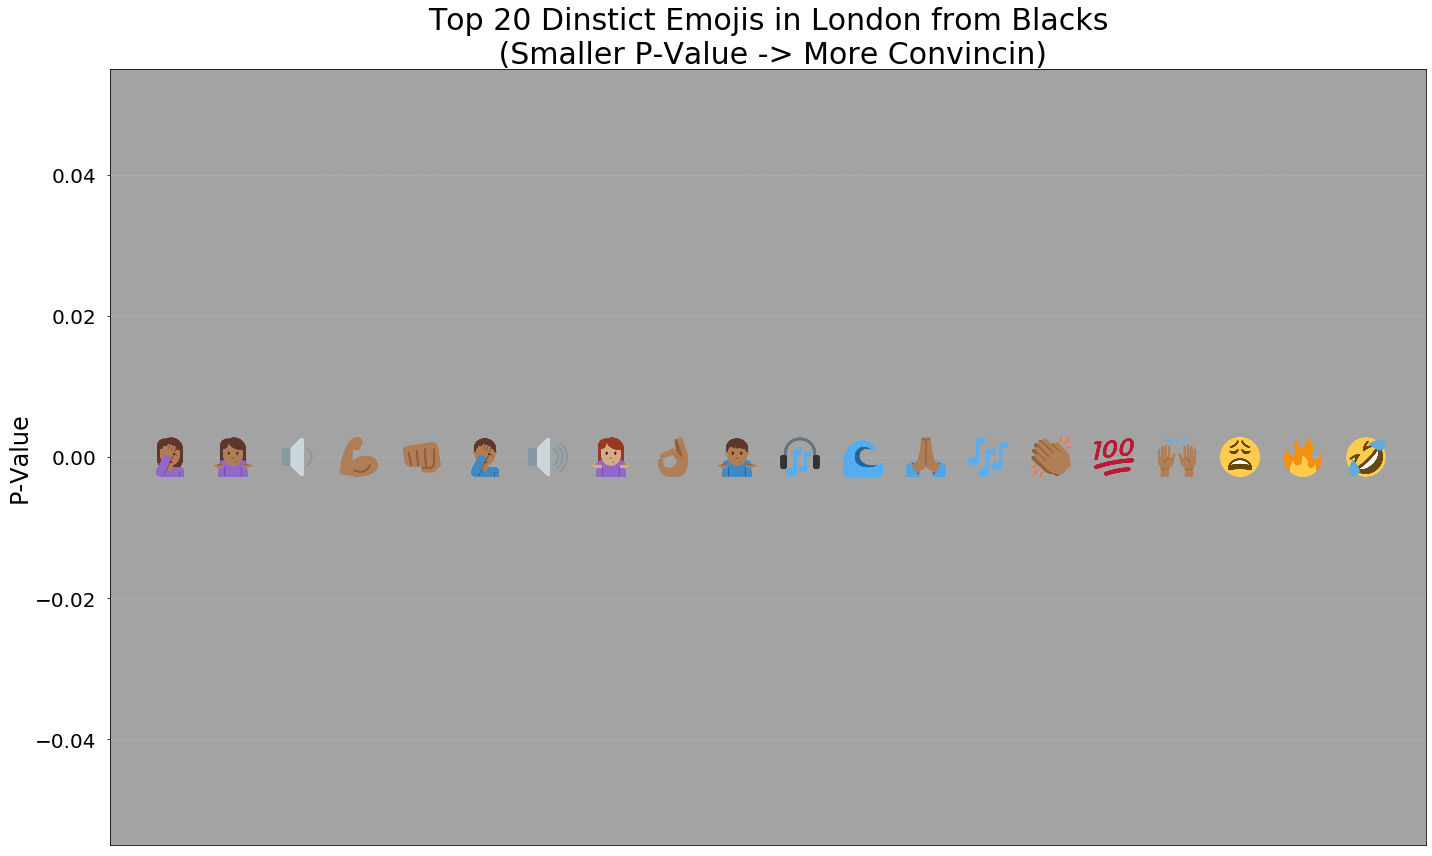

In [14]:
# Read from saved csv
df_to_plot_black_path = '/home/stelios/Desktop/Honours Project/Emojis-usage-in-social-media-by-demographics/Jupyter/P-values/chi2_joh_black_pvalues.csv'
df_to_plot_black = pd.read_csv(df_to_plot_black_path,index_col=None, header=0, low_memory = False)

# Top 20 Values
x=[]
y=[]
counter_20 = 0
for index, row in df_to_plot_black.iterrows():
    if(row['ethnicity']=='black'):
        counter_20 = counter_20 +1 
        x.append(row['Emoji'])
        y.append(row['P-value'])

        if(counter_20 ==20):
            break
            
# Set linespacing
x_linespace = linspace(0, 4*pi, num=20)

# Plot Chart
fig, ax = plt.subplots(figsize=(20,12))
ax.tick_params(axis='both', which='major', pad=10)
ax.set_facecolor('#{}'.format("a3a3a3"))
plt.grid(linestyle='--', linewidth=1,axis='y')
plt.plot(x_linespace, y,linewidth=0,color = 'grey',linestyle=':')
ax.get_xaxis().set_visible(False)
plt.yticks(fontsize =20)
plt.ylabel('P-Value', fontsize =24)
plt.title('Top 20 Dinstict Emojis in Johannesburg from Blacks\n (Smaller P-Value -> More Convincin)', fontsize =30)
plt.tight_layout()

# Change offest size
ax.yaxis.offsetText.set_fontsize(20)

# Set y-lim to 0
ax.set_ylim(bottom=0)

# Plot emojis on x-axis
bar_chart_plot_emojis(ax,fig,x,y)
plt.show()